<a href="https://colab.research.google.com/github/amanouz-mounir/Classification-of-Aviation-Incident-reports/blob/main/FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

On vérifie que le GPU est activé



In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

On importe les différents framework qu'on va utiliser

In [ ]:
!pip install transformers[torch]

import pandas as pd
import numpy as np
import torch

from torch.utils.data.dataset import Dataset
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split

# **Creation du dataframe des données**

On fabrique le dataframe des labels

In [ ]:

# Charger le fichier
df = pd.read_csv("TrainCategoryMatrix.txt", header=None)

# Binariser les valeurs (-1 devient 0, 1 reste 1)
df_binarized = df.replace(-1, 0)

print(df_binarized.shape)
# Afficher les premières lignes pour vérification
print(df_binarized.head())


(21519, 22)
   0   1   2   3   4   5   6   7   8   9   ...  12  13  14  15  16  17  18  \
0   0   1   0   0   0   1   1   0   0   0  ...   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   1   
2   0   1   0   0   0   0   0   0   0   0  ...   1   1   0   0   0   0   1   
3   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   1   0   
4   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

   19  20  21  
0   0   0   0  
1   0   0   0  
2   0   1   0  
3   0   0   0  
4   0   0   0  

[5 rows x 22 columns]


On importe les données textuelles pour les ajouter au dataframe des labels

In [ ]:
import pandas as pd

# Charger le fichier
file_path = "/content/TrainingData.txt"

print("Importation faite")

# Lire et structurer le fichier
data = []
current_index = None
current_text = []

with open(file_path, "r", encoding="utf-8") as file:
    for line in file:
        line = line.strip()
        if "~" in line:  # Nouvelle panne détectée
            if current_index is not None:  # Sauvegarde de l'ancienne panne
                data.append((current_index, " ".join(current_text)))
            current_index, text = line.split("~", 1)  # Séparer l'index et le texte
            current_index = int(current_index)  # Convertir l'index en entier
            current_text = [text]  # Démarrer un nouveau texte
        else:
            current_text.append(line)  # Ajouter la ligne à la panne en cours

# Ajouter la dernière panne
if current_index is not None:
    data.append((current_index, " ".join(current_text)))

# Créer un DataFrame texte
df_text = pd.DataFrame(data, columns=["Index", "Text"])

# 🔄 Fusionner en s'assurant que les indices correspondent
df_final = df_binarized.copy()
df_final["Text"] = df_final.index.map(df_text.set_index("Index")["Text"])

# 📌 Améliorer l'affichage en tronquant les textes longs
pd.set_option('display.max_colwidth', 100)  # Augmenter la largeur max des colonnes
print(df_final.head())  # Affichage propre
print(df_final.tail(10))

# 📤 Exporter si besoin
df_final.to_csv("Dataset_final_VRAI.csv", index=True)


Importation faite


FileNotFoundError: [Errno 2] No such file or directory: '/content/TrainingData.txt'

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
# Spécifie un répertoire pour télécharger les ressources nltk

# Téléchargement des ressources nécessaires
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

def clean_text(text):

    # 1. Supprimer les balises et valeurs inutiles comme [Missing Value] (non significatif)
    text = re.sub(r'\[Missing Value\]', '', text)


    # 2. Supprimer les caractères spéciaux, ponctuation et chiffres
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 3. Tokenisation : Diviser le texte en mots individuels (tokens)
    tokens = word_tokenize(text)

    # 4. Supprimer les mots vides (stopwords) : Les mots comme "the", "and" n'ont pas d'importance pour l'analyse
    stop_words = set(stopwords.words('english'))  # Liste de mots vides en anglais
    tokens = [word for word in tokens if word not in stop_words]


    # 5. Lemmatisation : Réduire les mots à leur forme de base (par exemple "running" devient "run")
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]


    # 6. Rejoindre les tokens pour reformer un texte nettoyé
    cleaned_text = ' '.join(tokens)

    return cleaned_text




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df_final['Text'] = df_final['Text'].astype(str).apply(clean_text)

In [ ]:
print(df_final.head())


   Indice  0  1  2  3  4  5  6  7  8  ...  13  14  15  16  17  18  19  20  21  \
0       1  0  1  0  0  0  1  1  0  0  ...   0   0   0   0   0   0   0   0   0   
1       2  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   1   0   0   0   
2       3  0  1  0  0  0  0  0  0  0  ...   1   0   0   0   0   1   0   1   0   
3       4  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   1   0   0   0   0   
4       5  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   

                                                Text  
0  locate distancemeasuringequipment FROM runway ...  
1  IN I BECAME AWARE THAT MY ULTRASONIC AND EDDY ...  
2  visualflightrules FROM foot PIERCE flightlevel...  
3  JUST PRIOR TO rotate A DEER RAN ONTO THE runwa...  
4  climb ON degree head TO foot GOT trafficalerta...  

[5 rows x 24 columns]


In [ ]:
# Sauvegarde du DataFrame nettoyé
df_final.to_csv("/content/Dataset_final_nettoye.csv", index=False)


# **Chargement des données de dataframe**

In [ ]:
# Charger le fichier CSV
df_final = pd.read_csv("/content/Dataset_final_nettoye.csv")
# Afficher les premières lignes du DataFrame
print(df_final.head())
print("Affichage de la taille du dataframe:", df_final.shape)

NameError: name 'pd' is not defined

# Préparation de l'entrainement

In [ ]:
test_split = 0.2
train_df, test_df = train_test_split(
    df_final,
    test_size=test_split,
)
print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 17215
Number of rows in test set: 4304


In [ ]:
# Define a list of columns that should not be chosen as label columns
not_chosen_columns = ['Indice', 'Text']

# Select label columns that are not in the list of not chosen columns
label_columns = [col for col in df_final.columns if col not in not_chosen_columns]

# Create a new DataFrame containing only the selected label columns
df_labels_train = train_df[label_columns]
df_labels_test = test_df[label_columns]


# Convert the label columns to lists for each row
labels_list_train = df_labels_train.values.tolist()
labels_list_test = df_labels_test.values.tolist()

NameError: name 'df_final' is not defined

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"
from torch.nn import BCEWithLogitsLoss



train_texts = train_df['Text'].tolist()
train_labels = labels_list_train

eval_texts = test_df['Text'].tolist()
eval_labels = labels_list_test

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

train_encodings = tokenizer(train_texts, padding="max_length", truncation=True, max_length=512)
eval_encodings = tokenizer(eval_texts, padding="max_length", truncation=True, max_length=512)


class TextClassifierDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

train_dataset = TextClassifierDataset(train_encodings, train_labels)
eval_dataset = TextClassifierDataset(eval_encodings, eval_labels)

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    problem_type="multi_label_classification",
    num_labels=22
)

training_arguments = TrainingArguments(
    output_dir=".",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
)

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


# Entrainement du modèle

In [ ]:
# Lancement de l'entraînement
trainer.train()


Epoch,Training Loss,Validation Loss
1,0.159500,0.147046
2,0.132300,0.134216
3,0.112200,0.128955


TrainOutput(global_step=3228, training_loss=0.1450630486971679, metrics={'train_runtime': 5129.8343, 'train_samples_per_second': 10.068, 'train_steps_per_second': 0.629, 'total_flos': 1.35908105439744e+16, 'train_loss': 0.1450630486971679, 'epoch': 3.0})

# Sauvegarde du modèle

In [ ]:
# Sauvegarder le modèle
trainer.save_model("mon_modele_sauvegardeF")
# Sauvegarder le tokenizer
tokenizer.save_pretrained("mon_modele_sauvegardeF")



('mon_modele_sauvegardeF/tokenizer_config.json',
 'mon_modele_sauvegardeF/special_tokens_map.json',
 'mon_modele_sauvegardeF/vocab.txt',
 'mon_modele_sauvegardeF/added_tokens.json',
 'mon_modele_sauvegardeF/tokenizer.json')

In [ ]:
import shutil

# Compresser le répertoire en fichier zip
shutil.make_archive('/content/mon_modele_sauvegardeF', 'zip', 'mon_modele_sauvegardeF')

'/content/mon_modele_sauvegardeF.zip'

# Chargement du modèle

Dezippage

In [ ]:
import zipfile

# Décompresser le fichier zip
with zipfile.ZipFile('/content/mon_modele_sauvegardeF.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/mon_modele_sauvegardeF')


Importation du modèle

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Recharger le modèle sauvegardé
model = AutoModelForSequenceClassification.from_pretrained('/content/mon_modele_sauvegardeF')

# Recharger le tokenizer sauvegardé
tokenizer = AutoTokenizer.from_pretrained('/content/mon_modele_sauvegardeF')


# Prédictions

tokenisation des textes de text_list à l’aide du tokenizer du modèle.

In [ ]:
sub_encodings = tokenizer(text_list, padding="max_length", truncation=True, max_length=512)


Creation d'une liste avec tout les textes de test nettoyés

In [ ]:
# Lecture du fichier TestData.txt
text_list = []
with open('TestData.txt', 'r') as file:
    lines = file.readlines()

# Séparer chaque ligne, appliquer la fonction de nettoyage, et ajouter au text_list
for line in lines:
    # Séparer le numéro et le texte
    num, text = line.split('~', 1)
    cleaned_text = clean_text(text)
    text_list.append(cleaned_text)

['AFTER takeoff ON runway A loudnoise WAS hear come FROM FRONT AREA OF aircraftFOR A WHILE I AND CREW THOUGHT IT WAS THE AIR drive generate THAT deploy FROM right NOSE OF aircraftUPON FURTHER troubleshoot FOUND THAT THE AIR drive generate COULD NOT HAVE deploy DUE TO ABSENCE OF icon AND message ON THE engineindicationandcrewalertingsystem systemWE immediate return TO THE airport FOR AN UNEVENTFUL landFURTHER examine AT THE GATE show THE OXYGEN accesspanel pop OPEN AFTER takeoff cause THE NOISEPRIOR TO flight THE normalpreflight show NO AJAR OR OPEN panel ON THE aircraftmoderateturbulence WAS encounter AFTER takeoffdue TO STRONG crosswind AND lowlevelwindshearadvisories IN EFFECT', 'taxi OFF THE parkingramp THE brake system fail TO STOP THE aircraftLATER determine TO BE A BAD TRUNION SWITCH IN THE right maingear NEITHER pilot HAD ani control OVER THE aircraft speed AND DUE TO frequencycongestion WE COULD NOT ALERT ground OF OUR problemBECAUSE OF THIS WE WERE UNABLE TO HOLD SHORT OF THE 

In [ ]:
print(len(text_list))
print(text_list[0])
print(text_list[-1])

7077
AFTER takeoff ON runway A loudnoise WAS hear come FROM FRONT AREA OF aircraftFOR A WHILE I AND CREW THOUGHT IT WAS THE AIR drive generate THAT deploy FROM right NOSE OF aircraftUPON FURTHER troubleshoot FOUND THAT THE AIR drive generate COULD NOT HAVE deploy DUE TO ABSENCE OF icon AND message ON THE engineindicationandcrewalertingsystem systemWE immediate return TO THE airport FOR AN UNEVENTFUL landFURTHER examine AT THE GATE show THE OXYGEN accesspanel pop OPEN AFTER takeoff cause THE NOISEPRIOR TO flight THE normalpreflight show NO AJAR OR OPEN panel ON THE aircraftmoderateturbulence WAS encounter AFTER takeoffdue TO STRONG crosswind AND lowlevelwindshearadvisories IN EFFECT
clear instrumentlandingsystemrunway wind degree AT knot gust TO knotdeclinevector instrumentlandingsystemrunway moderateturbulence ON DOWNWINDclear instrumentlandingsystemrunway APPROXIMATE mile OUTSIDE mark GEAR DOWN flap degree SPEED knot AUTOPILOT engage locate AND GLIDESLOPE captureWITHOUT warn throttle 

On initialise les prédictions

In [ ]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

NameError: name 'model' is not defined

On passe nos textes dans le modèle pour la prédiction

In [ ]:
all_probabilities = []

for text in text_list:
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    inputs = inputs.to(device)

    with torch.no_grad():  # On ne calcule pas les gradients
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.sigmoid(logits)  # Appliquer la sigmoïde pour obtenir des probabilités

    all_probabilities.append(probabilities)


NameError: name 'text_list' is not defined

Sauvegarde des probabilités

In [ ]:
all_probabilities_array = np.array([tensor.cpu().numpy() for tensor in all_probabilities])
np.save("all_probabilities.npy", all_probabilities_array)

NameError: name 'np' is not defined

all_probabilities = [
    tensor([0.12, 0.45, 0.67, ..., 0.89]),  # Probabilités pour le 1er texte
    tensor([0.34, 0.23, 0.78, ..., 0.56]),  # Probabilités pour le 2e texte
    ...
    tensor([0.56, 0.12, 0.34, ..., 0.78]),  # Probabilités pour le 7077e texte
]. On a une liste de tenseur de probabilité. Il y a autant delements que de textes dans cette liste. Et chaque tenseur est de dimension 21.

In [ ]:
new_threshold = 0.3
df_submission = pd.DataFrame(columns=label_columns)

for row in all_probabilities_array:
    mask = row >= new_threshold

    if mask.any():  # S'il y a des probabilités supérieures au seuil
        thresholded_row = mask.astype(int)
    else:  # Sinon, on prend l'étiquette avec la probabilité la plus élevée
        top_1_index = np.argmax(row)
        thresholded_row = np.zeros(len(label_columns), dtype=int)
        thresholded_row[top_1_index] = 1

    thresholded_row = thresholded_row.reshape(1, -1)

    # Utilisation de pd.concat pour ajouter une ligne
    df_submission = pd.concat([df_submission, pd.DataFrame(thresholded_row, columns=label_columns)], ignore_index=True)

df_submission = df_submission.astype(int)


NameError: name 'pd' is not defined

Affichage du dataframe des prédictions

In [ ]:
# Afficher les premières lignes du DataFrame
print(df_submission.head())

# Sauvegarder le DataFrame dans un fichier CSV (si tu veux l'examiner plus tard)
df_submission.to_csv('predictions2.csv', index=False)


   0  1  2  3  4  5  6  7  8  9  ...  12  13  14  15  16  17  18  19  20  21
0  0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   1   0   0   0
1  0  1  0  0  1  0  0  0  0  0  ...   0   0   0   0   0   1   1   0   0   0
2  1  1  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   1   0   0   0
3  0  1  0  0  0  1  1  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
4  0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   1   1   0   0

[5 rows x 22 columns]


Tracé de l'histogramme des sommes des valeurs

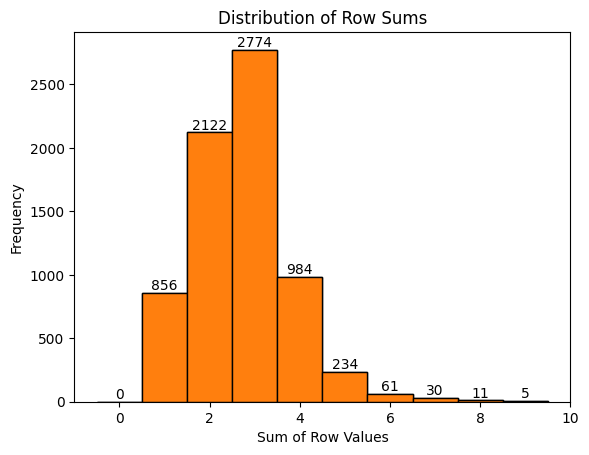

In [ ]:
import matplotlib.pyplot as plt  # Assure-toi que cette ligne est incluse

row_sums = df_submission.sum(axis=1)

# Tracer l'histogramme avec des bins plus adaptés
plt.hist(row_sums, bins=range(0, 11), edgecolor='k', align='left')

# Ajouter des étiquettes sur les axes
plt.xlabel('Sum of Row Values')
plt.ylabel('Frequency')
plt.title('Distribution of Row Sums')

# Ajouter des étiquettes avec le nombre de valeurs dans chaque bin
n, bins, patches = plt.hist(row_sums, bins=range(0, 11), edgecolor='k', align='left')

# Placer les labels sur chaque barre
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, n[i],
             str(int(n[i])), ha='center', va='bottom')

# Afficher le graphique
plt.show()


# Binarisation de TestTruth.csv

In [ ]:
import pandas as pd

# Charger le fichier CSV
df = pd.read_csv('TestTruth.csv',header=None)

# Remplacer les -1 par 0
df = df.replace(-1, 0)

# Sauvegarder le tableau modifié dans un nouveau fichier CSV
df.to_csv('TestTruth_modifiedF.csv', index=False)




# Comparaison avec la vérité terrain et calcul du F1-score

In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Charger les prédictions et la vérité terrain
predictions = pd.read_csv('submission.csv', header=0) #Header=0 ca veut dire que la premiere ligne représente les labels
truth = pd.read_csv('TestTruth_modifiedF.csv', header=0)

# Assurer que les dimensions des données sont les mêmes
assert predictions.shape == truth.shape, "Les dimensions des prédictions et de la vérité terrain ne correspondent pas."

# Calculer les métriques
precision = precision_score(truth, predictions, average='samples')
recall = recall_score(truth, predictions, average='samples')
f1 = f1_score(truth, predictions, average='samples')

# Afficher les résultats
print(f"Précision moyenne: {precision:.4f}")
print(f"Rappel moyen: {recall:.4f}")
print(f"F-mesure moyenne: {f1:.4f}")


Précision moyenne: 0.6228
Rappel moyen: 0.8220
F-mesure moyenne: 0.6662


# Optimisation du Treshhold

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

# Charger les données de vérité terrain
truth = pd.read_csv('TestTruth_modifiedF.csv', header=0)

# Vérifier les dimensions des prédictions et de la vérité terrain
#print(f"Dimensions de all_probabilities_array: {np.array(all_probabilities_array).shape}")
#print(f"Dimensions de truth: {truth.shape}")

# Aplatir all_probabilities_array de (7077, 1, 22) à (7077, 22)
all_probabilities_array = np.squeeze(all_probabilities_array)  # Supprime la dimension de taille 1

# Vérifier que les dimensions sont maintenant compatibles
assert all_probabilities_array.shape == truth.shape, "Les dimensions des prédictions et de la vérité terrain ne correspondent pas."

# Initialiser les colonnes des labels
label_columns = truth.columns  # Cela suppose que 'truth' contient les étiquettes binaires

# Fonction pour évaluer un seuil donné
def evaluate_threshold(predictions, truth, threshold):
    # Appliquer le seuil pour obtenir des prédictions binaires
    thresholded_predictions = (predictions >= threshold).astype(int)

    # Calculer le score F1
    return f1_score(truth, thresholded_predictions, average='samples')  # Moyenne pour multilabel

# Tester différents seuils de 0 à 1
thresholds = np.linspace(0, 1, 101)  # De 0 à 1 avec un pas de 0.01
f1_scores = []

# Calculer les scores F1 pour chaque seuil
for threshold in thresholds:
    f1 = evaluate_threshold(all_probabilities_array, truth.values, threshold)
    f1_scores.append(f1)

print(f1_scores)
# Trouver le seuil optimal qui maximise le score F1
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Le seuil optimal est : {optimal_threshold}")
print(f"Le score F1 correspondant est : {np.max(f1_scores)}")

[0.15949419820719674, 0.31888160081939176, 0.41866487563079596, 0.4799501909285264, 0.5202415449302099, 0.5466037386195952, 0.567463998773574, 0.5835617127192636, 0.5958491308303698, 0.6065954341216921, 0.6156708942985268, 0.6224754638506991, 0.6285226817788694, 0.6340505992672387, 0.6384149807865648, 0.6421408748479699, 0.6454870101891521, 0.6483374324969717, 0.6511911947078892, 0.6530345599997497, 0.6551280500118492, 0.6567915655583662, 0.6592091689933498, 0.6610198483050889, 0.6616897826757439, 0.6627508791162383, 0.6633174755702995, 0.6641847758865189, 0.6653740086781256, 0.665851364443739, 0.6662314021682397, 0.6659195415765996, 0.666065883075209, 0.665762961152957, 0.6652690812398315, 0.6650361276580014, 0.6644176984681436, 0.6636301799718503, 0.6623403302928526, 0.6615058179068353, 0.6614100765859986, 0.6608495040669691, 0.6593744801036026, 0.6587477600194853, 0.6574070529348189, 0.6560622474569062, 0.6547774215641956, 0.6543590897978351, 0.6533603970017704, 0.6512134710311904, 